# Test : vehicle detection

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import sys
sys.path.append("../common/")

import cv2
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS, TRAIN_DATA, TRAIN_WKT
from image_utils import get_image_data, get_image_tile_data, normalize
from visu_utils import display_img_1b, display_labels, plt_st

In [4]:
from glob import glob
all_train_ids = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_ids = np.array([s[len(TRAIN_DATA)+1:-4] for s in all_train_ids if 'mean' not in s and 'std' not in s])
print "First & last train ids : ", all_train_ids[0], all_train_ids[-1], len(all_train_ids)

First & last train ids :  6010_1_2 6170_4_1 25


In [5]:
LABELS

['None',
 'Buildings',
 'Misc. Manmade structures',
 'Road',
 'Track',
 'Trees',
 'Crops',
 'Waterway',
 'Standing water',
 'Vehicle Large',
 'Vehicle Small']

In [6]:
from data_utils import get_image_ids
gb = TRAIN_WKT[~TRAIN_WKT['MultipolygonWKT'].str.contains("EMPTY")].groupby('ClassType')
vehicles_road_train = get_image_ids([10, 9, 3], gb)
vehicles_road_train = get_image_ids([10, 9], gb)
print len(vehicles_road_train)

13


Input data :  3b and MS pensharpened

In [7]:
np.random.shuffle(vehicles_road_train)
ll = int(len(vehicles_road_train)*0.8)
train_ids = vehicles_road_train[:ll]
val_ids = vehicles_road_train[ll:]

In [8]:
tile_size = (128, 128)
labels = np.array([9, 10]) # Labels to predict
labels_data = np.array([9, 10, 3, 4]) # Labels to provide from dataset
# labels_data = labels # Labels to provide from dataset
channels = np.array(list(range(8)))

In [9]:
from image_utils import imwrite, compute_mean_std_on_images
from geo_utils.GeoImage import GeoImage

def compute_mean_std(image_type, feature_wise, out_shape):
    s = ''
    if feature_wise:
        s = "_feature_wise"
    
    mean_fname = os.path.join(TRAIN_DATA, 'mean_%s_image%s.tif' % (image_type, s))
    std_fname = os.path.join(TRAIN_DATA, 'std_%s_image%s.tif' %  (image_type, s))
    if not os.path.exists(mean_fname) or not os.path.exists(std_fname):
        logging.getLogger().setLevel(logging.INFO)
        mean_image, std_image = compute_mean_std_on_images(train_ids, image_type, feature_wise=feature_wise, out_shape=out_shape)
        logging.getLogger().setLevel(logging.ERROR)
        imwrite(mean_fname, mean_image)
        imwrite(std_fname, std_image)
    else:
        mean_image = GeoImage(mean_fname).get_data()
        std_image = GeoImage(std_fname).get_data()
    return mean_image, std_image

img_shape = (860*4, 860*4, 8)
feature_wise = True
mean_image, std_image = compute_mean_std('ms_pan', feature_wise, img_shape)
        
# print "RGB"    
# print mean_rgb_image.shape, std_rgb_image.shape
# print mean_rgb_image.min(), mean_rgb_image.max(), std_rgb_image.min(), std_rgb_image.max()

print "MS PAN" 
print mean_image.shape, std_image.shape
print mean_image.min(), mean_image.max(), std_image.min(), std_image.max()

# print len(train_ids), len(val_ids)

logging.getLogger().setLevel(logging.ERROR)

No handlers could be found for logger "geo_utils.GeoImage"


MS PAN
(3440L, 3440L, 8L) (3440L, 3440L, 8L)
317.251 780.71 33.2224 109.153


In [10]:
from data_utils import get_image_ids
from training_utils import tile_iterator


def generate_images(image_ids_to_use, batch_size, resolution_level=1):
    
    label_indices = np.array([i for i, l in enumerate(labels_data) if l in labels])

    while True:
        
        X = np.zeros((batch_size, len(channels))+tile_size, dtype=np.float32)
        Y = np.zeros((batch_size, len(labels))+tile_size, dtype=np.float32)
        tiles = tile_iterator(image_ids_to_use,
                              channels,
                              labels_data, 
                              presence_percentage=5.0,
                              image_type='ms_pan',
                              label_type='label',
                              tile_size=tile_size, 
                              mean_image=mean_image,
                              std_image=std_image,
                              resolution_levels=(resolution_level,),
                              verbose_image_ids=False,
                              balance_classes=2
                             )
        counter = 0
        for x, y in tiles:     
            
            x = x.transpose([2,0,1])
            y = y.transpose([2,0,1])

            X[counter,:,:,:] = x
            Y[counter,:,:,:] = y[label_indices,:,:]
            counter += 1
            if counter == batch_size:
                yield (X, Y)
                counter = 0


Training class groups : number of pixels x appearence frequency ~ probability that a pixel of the image is of a class

1. `Buildings` and `Misc. Manmade structures` and `Track` : [1, 2, 4]
2. `Standing water` and `Road` and `Waterway` : [8, 3, 7]
3. `Trees` and `Crops`: [5, 6]
4. `Vehicle Small` : [10]
5. `Vehicle Large` : [9]

In [11]:
batch_size = 5
train_data_gen = generate_images(train_ids, batch_size)

(5L, 8L, 128L, 128L) (5L, 2L, 128L, 128L)
-5.15897 13.467 0.0 1.0


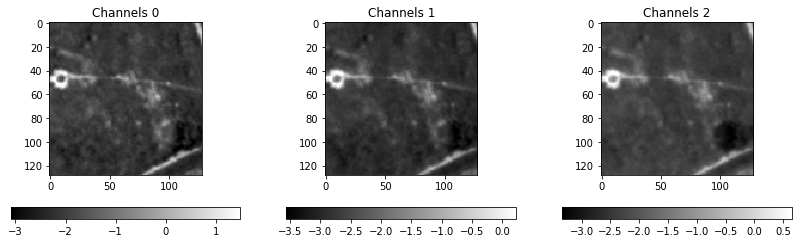

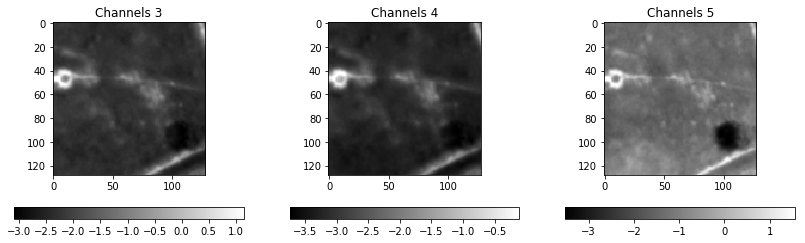

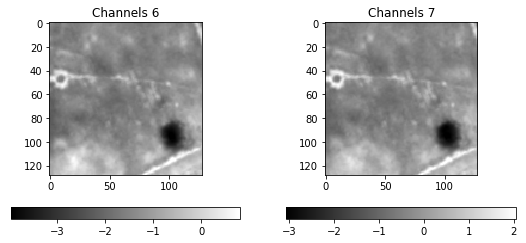

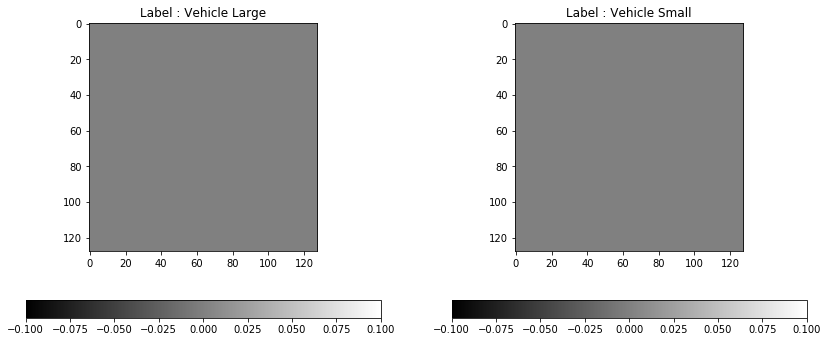

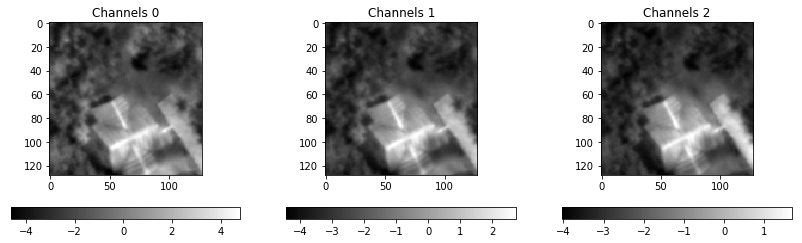

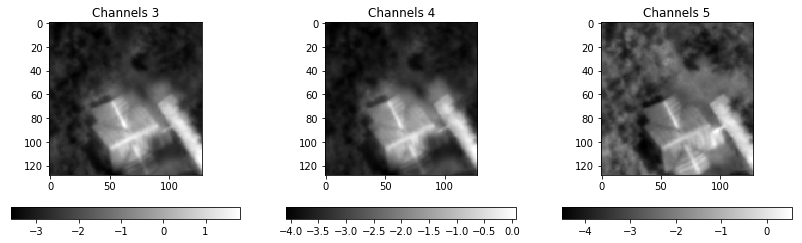

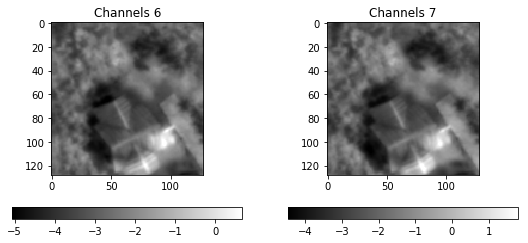

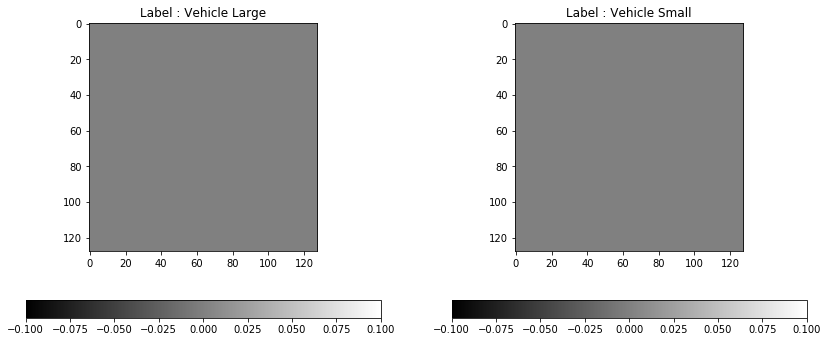

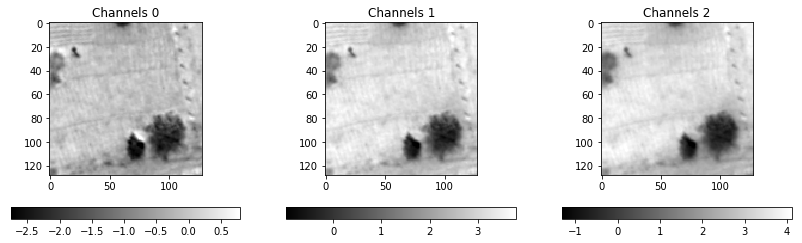

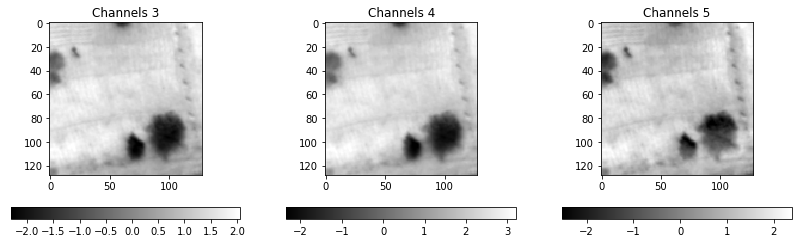

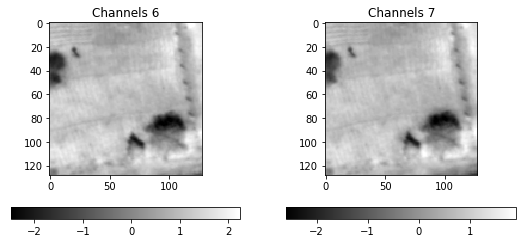

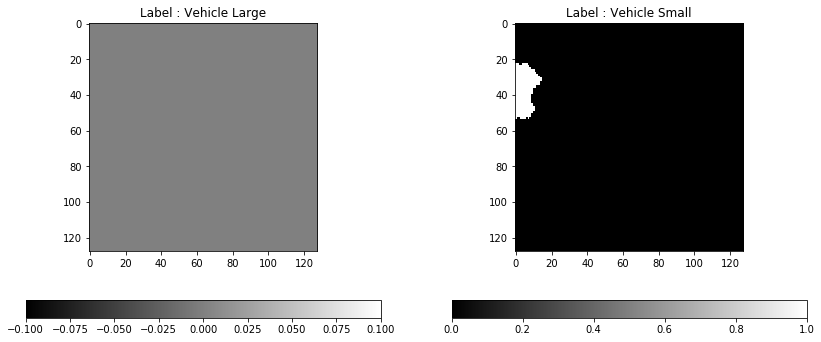

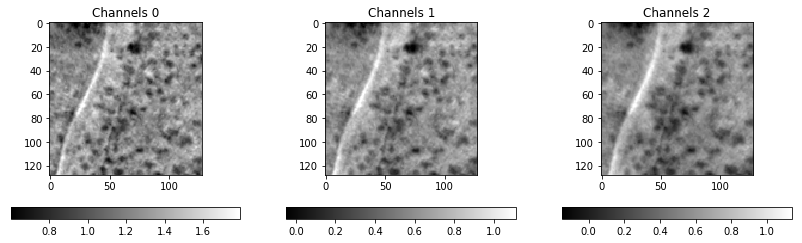

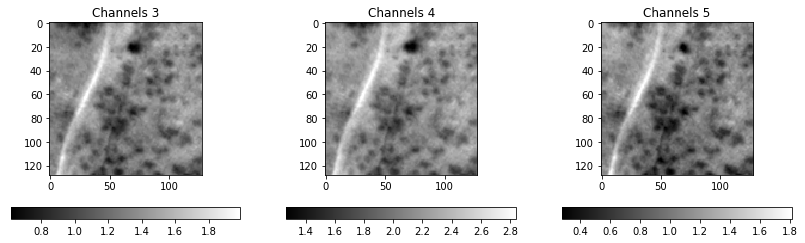

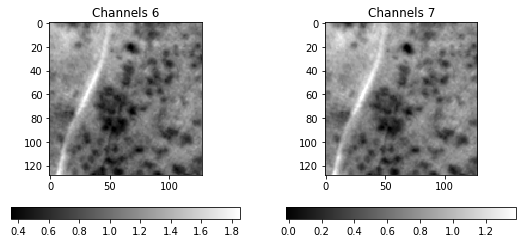

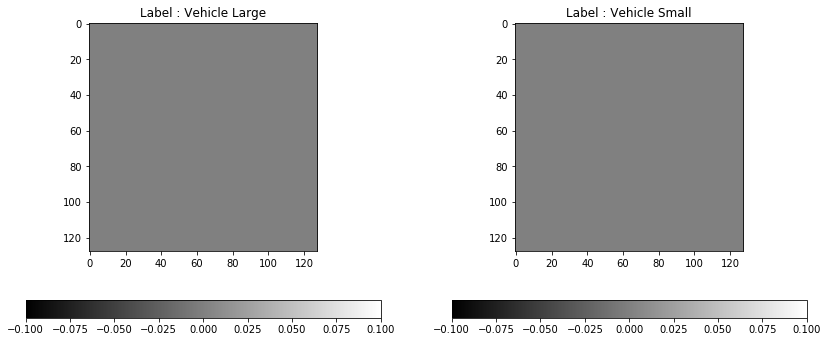

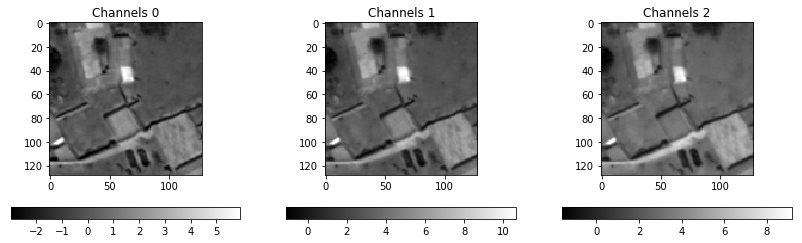

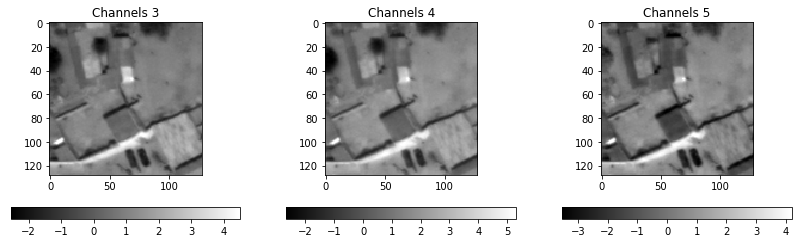

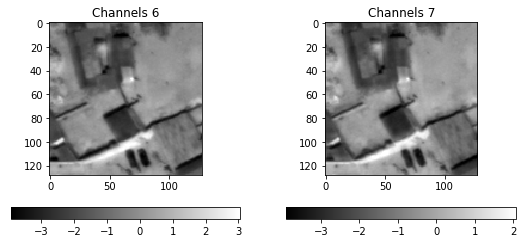

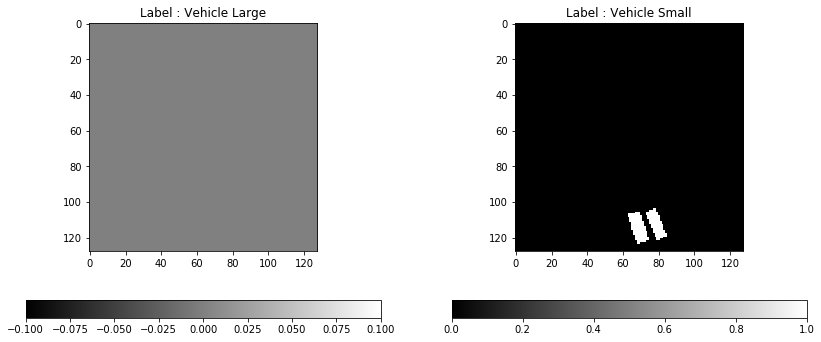

In [12]:
for X, Y in train_data_gen:
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    _n_labels = len(labels)
    _n_channels = min(15, len(channels))
    for i in range(batch_size):
        
        n, m = 3, int(_n_channels * 1.0 / 3.0 + 1.0)
        for j in range(_n_channels):
            if j % m == 0:
                plt.figure(figsize=(14, 4))                
            plt.subplot(1,m,j % m +1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if _n_labels < 8:
            n, m = 1, _n_labels
        else:
            n, m = 3, int(_n_labels * 1.0 / 3.0 + 1.0), 
        for j in range(_n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

In [76]:
val_data_gen = generate_images(val_ids, batch_size)

(5L, 8L, 128L, 128L) (5L, 2L, 128L, 128L)
-5.16284 6.54675 0.0 1.0


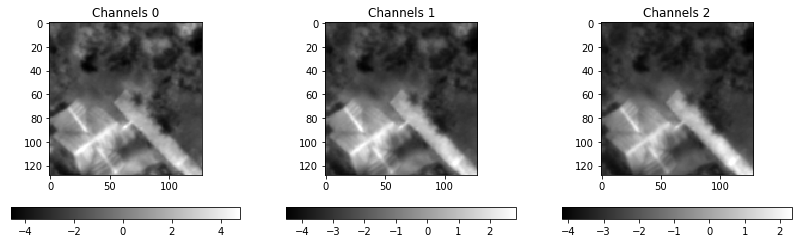

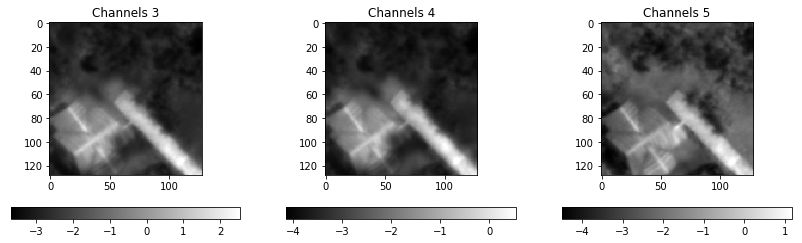

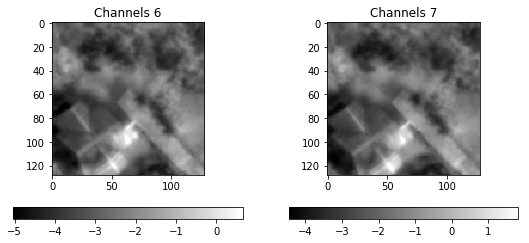

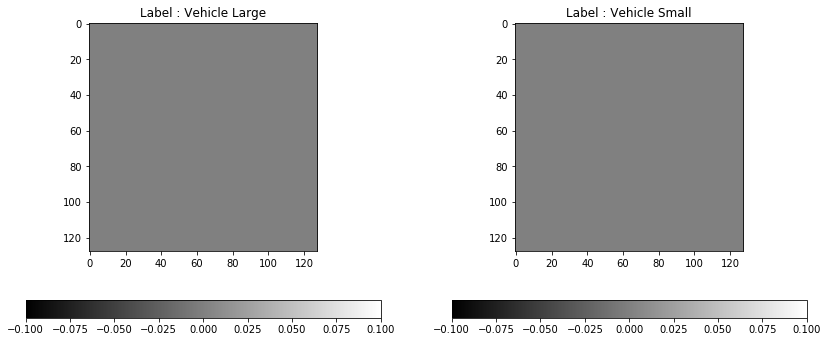

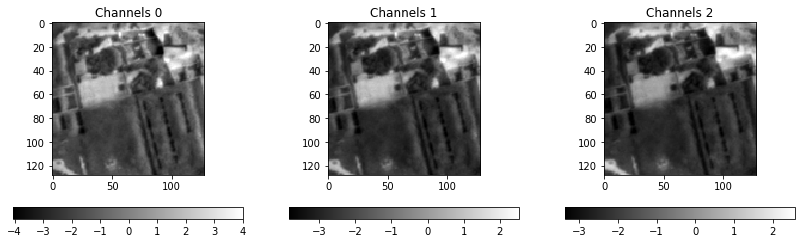

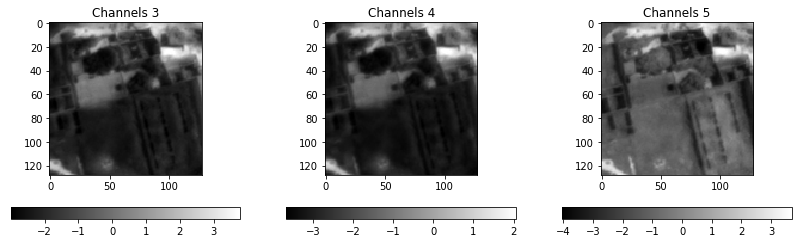

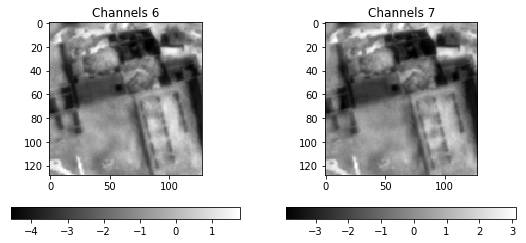

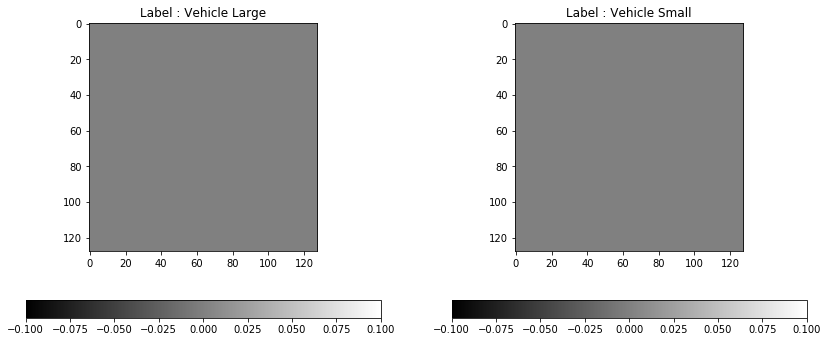

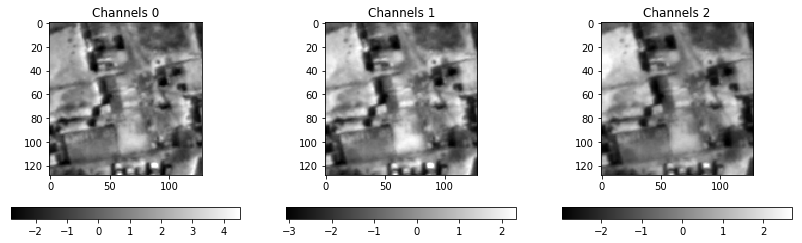

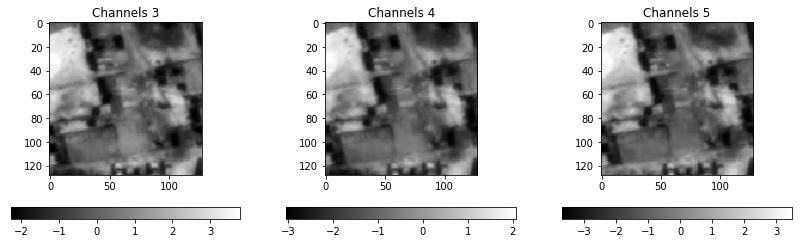

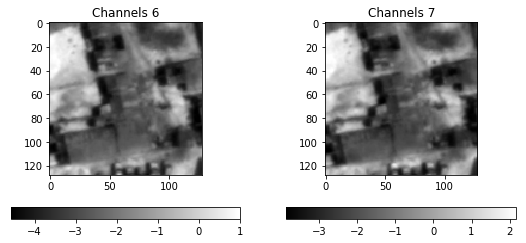

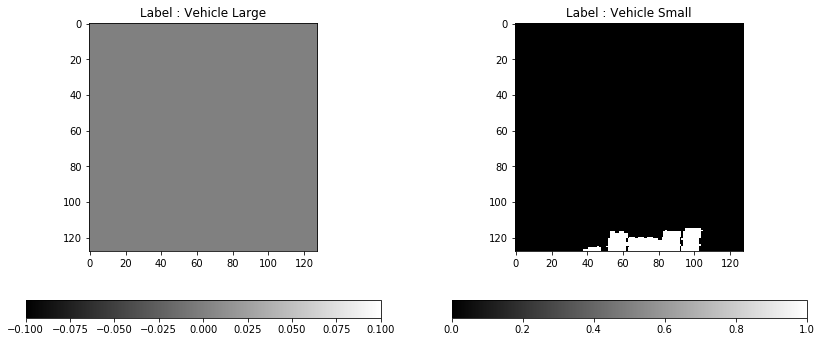

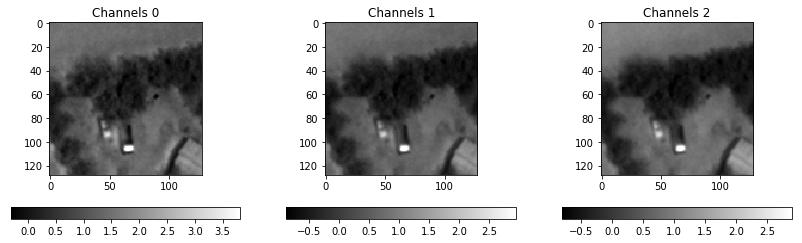

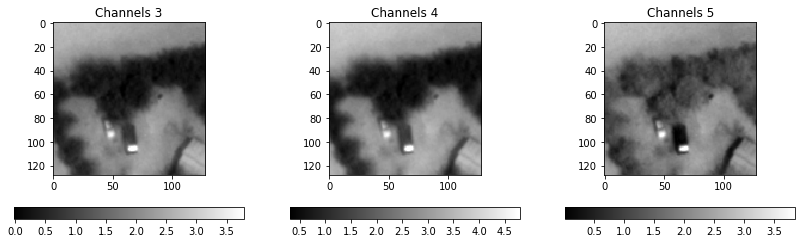

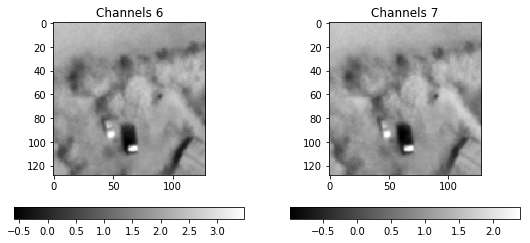

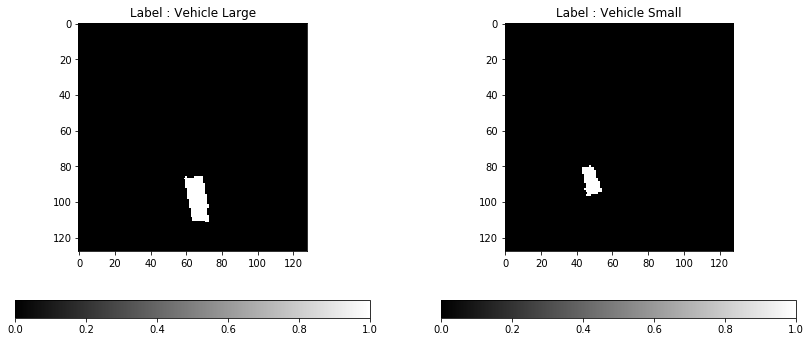

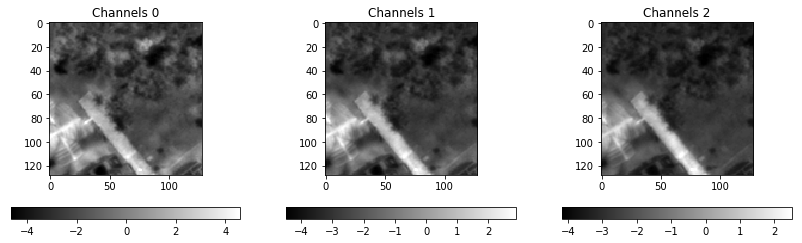

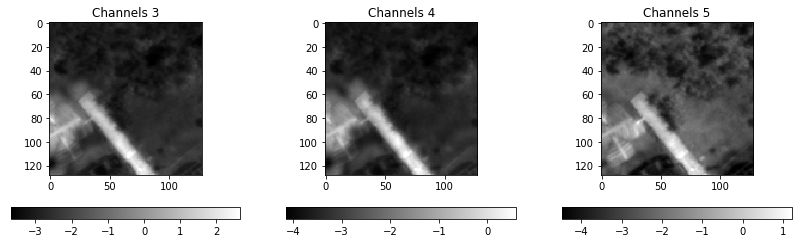

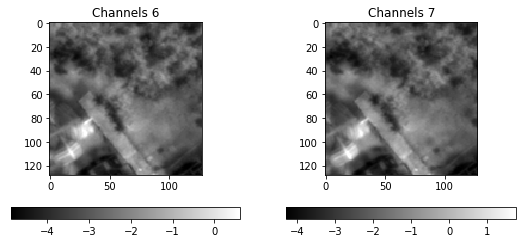

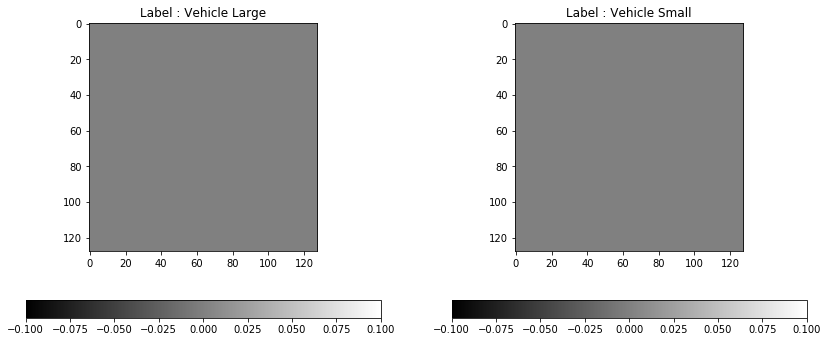

In [15]:
for X, Y in train_data_gen:
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    _n_labels = len(labels)
    _n_channels = min(15, len(channels))
    for i in range(batch_size):
        
        n, m = 3, int(_n_channels * 1.0 / 3.0 + 1.0)
        for j in range(_n_channels):
            if j % m == 0:
                plt.figure(figsize=(14, 4))                
            plt.subplot(1,m,j % m +1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if _n_labels < 8:
            n, m = 1, _n_labels
        else:
            n, m = 3, int(_n_labels * 1.0 / 3.0 + 1.0), 
        for j in range(_n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

In [11]:
from keras.optimizers import Adam, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

#from cosmiqnet import cosmiqnet_zero
from another_unet import unet_original, unet_3d

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5110)


In [29]:
model = unet_3d(len(labels), len(channels), tile_size[1], tile_size[0])
#model = unet_original(len(labels), len(channels), tile_size[1], tile_size[0])

weights_filename = os.path.join("weights", "vehicles_%i_ms_unet_3d.h5" % (labels[0]))

In [30]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 8, 128, 128)   0                                            
____________________________________________________________________________________________________
reshape_9 (Reshape)              (None, 1, 8, 128, 128 0           input_9[0][0]                    
____________________________________________________________________________________________________
convolution3d_24 (Convolution3D) (None, 64, 4, 64, 64) 1792        reshape_9[0][0]                  
____________________________________________________________________________________________________
leakyrelu_17 (LeakyReLU)         (None, 64, 4, 64, 64) 0           convolution3d_24[0][0]           
___________________________________________________________________________________________

In [19]:
# if os.path.exists(weights_filename + ".best"):
#     model.load_weights(weights_filename + ".best")
#     print 'Loaded weights: ', weights_filename + ".best"

In [31]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)

In [32]:
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'recall', 'precision'])

In [33]:
# foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 4
samples_per_epoch = 512
nb_val_samples = 64


print batch_size, samples_per_epoch, nb_val_samples
try:
    history = model.fit_generator(
        generate_images(train_ids, batch_size),
        samples_per_epoch=samples_per_epoch, 
        nb_epoch=20,
        validation_data=generate_images(val_ids, batch_size),
        nb_val_samples=nb_val_samples,
        callbacks=[model_checkpoint],
        verbose=2
    )
except KeyboardInterrupt:    
    model.save_weights(weights_filename + '.last')


16 512 64
Epoch 1/20


MemoryError: Error allocating 536870912 bytes of device memory (CNMEM_STATUS_OUT_OF_MEMORY).
Apply node that caused the error: GpuAlloc(GpuDimShuffle{0,1,2,3,x,4}.0, Elemwise{switch,no_inplace}.0, Elemwise{switch,no_inplace}.0, Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}}.0, Elemwise{switch,no_inplace}.0, TensorConstant{2}, Elemwise{switch,no_inplace}.0)
Toposort index: 885
Inputs types: [CudaNdarrayType(float32, (False, False, False, False, True, False)), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int8, scalar), TensorType(int64, scalar)]
Inputs shapes: [(16, 128, 8, 64, 1, 64), (), (), (), (), (), ()]
Inputs strides: [(4194304, 32768, 4096, 64, 0, 1), (), (), (), (), (), ()]
Inputs values: ['not shown', array(16L, dtype=int64), array(128L, dtype=int64), array(8L, dtype=int64), array(64L, dtype=int64), array(2, dtype=int8), array(64L, dtype=int64)]
Outputs clients: [[GpuReshape{5}(GpuAlloc.0, MakeVector{dtype='int64'}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [22]:
from predictions_utils import compute_predictions
from metrics import score

In [39]:
def decision_func(img_pred, threshold=0.5):
    out = img_pred.copy()
    out[out < threshold] = 0.0
    out[out >= threshold] = 1.0
    return out.astype(np.uint8)

In [74]:
validation_score = 0
for image_id in val_ids:
    Y_predictions = compute_predictions(image_id, model, channels=channels, tile_size=tile_size, mean_image=mean_image, std_image=std_image)
    labels_image = get_image_data(image_id, 'label')
    h, w, _ = labels_image.shape
    s = score(labels_image[:,:,labels], decision_func(Y_predictions[:h,:w,:]))
    print "-- score :", image_id, s
    validation_score += s
validation_score *= 1.0/len(val_ids)
print "Validation score :", validation_score

-- score : 6100_1_3 4.09644e-16
-- score : 6140_1_2 0.5
-- score : 6120_2_2 4.89947e-16
Validation score : 0.166666666667


In [67]:
image_id = val_ids[1]
img_pan = get_image_data(image_id, 'pan')
labels_image = get_image_data(image_id, 'label')
Y_predictions = compute_predictions(image_id, model, channels=channels, tile_size=tile_size, mean_image=mean_image, std_image=std_image)

In [68]:
print Y_predictions.shape
for i in range(Y_predictions.shape[2]):
    print LABELS[labels[i]], Y_predictions[:,:,i].max()

(3500L, 3500L, 2L)
Vehicle Large 0.00316205
Vehicle Small 0.00804594


In [69]:
print labels_image.shape
for l in labels:
    print LABELS[l], labels_image[:,:,l].max()

(3348L, 3396L, 11L)
Vehicle Large 0
Vehicle Small 1


In [71]:
np.where(Y_predictions[:,:,1] > 0.2), np.where(labels_image[:,:,labels[1]] > 0.5)

((array([], dtype=int64), array([], dtype=int64)),
 (array([  81,   81,   82, ..., 3227, 3228, 3228], dtype=int64),
  array([562, 563, 562, ..., 735, 732, 733], dtype=int64)))

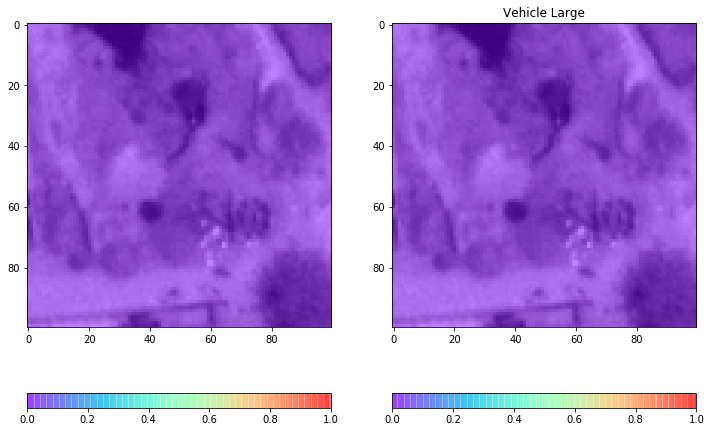

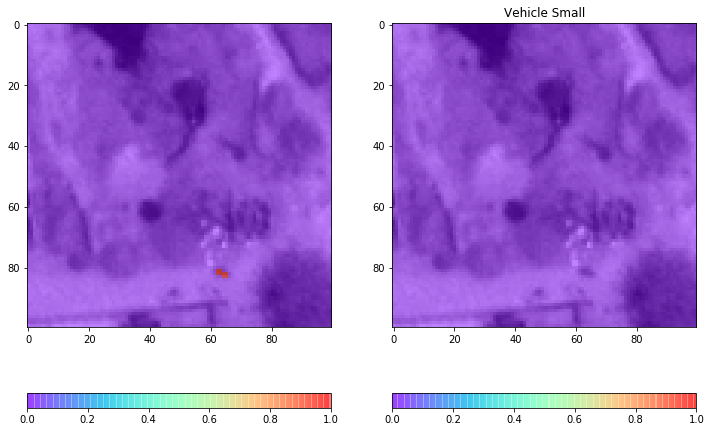

In [72]:
roi = [500, 0, 600, 100]
# roi = None
ll = Y_predictions.shape[2]
h, w = img_pan.shape
for i in range(ll):
    plt_st(12,8)
    plt.subplot(121)
    display_img_1b(img_pan, roi, no_colorbar=True)
    display_img_1b(labels_image[:,:,labels[i]], roi, alpha=0.5, cmap='rainbow', clim=[0, 1])
    plt.subplot(122)
    plt.title("%s" % LABELS[labels[i]])
    display_img_1b(img_pan, roi, no_colorbar=True)
    display_img_1b(decision_func(Y_predictions[:h,:w,i], 0.2), roi, alpha=0.5, cmap='rainbow', clim=[0, 1])
    